<a href="https://colab.research.google.com/github/atharvakale343/682-final-project/blob/main/experiments_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path

# !unzip "/content/drive/MyDrive/cs682/archive" &> /dev/null

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision

import numpy as np

In [ ]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

Preprocessing Data

In [ ]:
# Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a consistent size
    transforms.ToTensor(),          # Convert PIL Image to tensor
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize for 3-channel image
])

# Load datasets
# train_dataset = datasets.ImageFolder(root= 'train', transform=transform)
# test_dataset = datasets.ImageFolder(root= 'test', transform=transform)
train_dataset = dset.CIFAR10('./cs682/datasets', train=True, download=True,
                             transform=transform)
val_dataset = dset.CIFAR10('./cs682/datasets', train=True, download=True,
                           transform=transform)
test_dataset = dset.CIFAR10('./cs682/datasets', train=False, download=True,
                            transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Optional: get class names
class_names = train_dataset.classes
print("Classes:", class_names)


100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


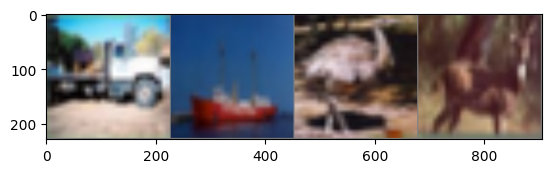

truck  ship  bird  deer


In [ ]:
# prompt: display some images of each class from cifar 10 dataset

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))


In [ ]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [ ]:

def train_part34(model, optimizer, tr_loader, val_loader, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(tr_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(val_loader, model)
                print()

In [ ]:
# prompt: use resnet 18 to do image classification of cifar-10. use test set to get accuracy

import torch.nn as nn
import torchvision.models as models

# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer for 10 classes (CIFAR-10)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Move the model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


In [ ]:
# Training loop (example - adjust as needed)
num_epochs = 1
model.train()
train_part34(model, optimizer, train_loader, val_loader, epochs=num_epochs)

# Evaluation on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


Iteration 0, loss = 2.5738
Checking accuracy on validation set
Got 5248 / 50000 correct (10.50)

Iteration 100, loss = 0.7017
Checking accuracy on validation set
Got 37606 / 50000 correct (75.21)

Iteration 200, loss = 0.5413
Checking accuracy on validation set
Got 42442 / 50000 correct (84.88)

Iteration 300, loss = 0.5190
Checking accuracy on validation set
Got 44546 / 50000 correct (89.09)

Iteration 400, loss = 0.3816
Checking accuracy on validation set
Got 45236 / 50000 correct (90.47)

Iteration 500, loss = 0.2126
Checking accuracy on validation set
Got 45809 / 50000 correct (91.62)

Iteration 600, loss = 0.4003
Checking accuracy on validation set
Got 46331 / 50000 correct (92.66)

Iteration 700, loss = 0.2294
Checking accuracy on validation set
Got 46557 / 50000 correct (93.11)

Iteration 800, loss = 0.1223
Checking accuracy on validation set
Got 46678 / 50000 correct (93.36)

Iteration 900, loss = 0.2636
Checking accuracy on validation set
Got 46922 / 50000 correct (93.84)

Ite

In [ ]:
# prompt: save the model checkpoint in google drive

# Save the model checkpoint to Google Drive
checkpoint_path = '/content/drive/MyDrive/cs682/resnet18_cifar10_checkpoint.pth'
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, checkpoint_path)

print(f"Model checkpoint saved to: {checkpoint_path}")


NameError: name 'num_epochs' is not defined

In [ ]:
# prompt: load the model from checkpoint stored at /content/drive/MyDrive/cs682/resnet18_cifar10_checkpoint.pth into a variable called `model`

checkpoint = torch.load('/content/drive/MyDrive/cs682/resnet18_cifar10_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
print(f"Loaded model from epoch {epoch}")


Loaded model from epoch 1


In [ ]:
import torch
import torch.nn.functional as F

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)

def pgd_attack(model, image, target, epsilon, alpha=0.01, iters=10):
    perturbed_image = image.clone().detach().to(image.device)
    perturbed_image.requires_grad = True

    for _ in range(iters):
        output = model(perturbed_image)
        loss = F.cross_entropy(output, target)
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            grad_sign = perturbed_image.grad.sign()
            perturbed_image = perturbed_image + alpha * grad_sign
            delta = torch.clamp(perturbed_image - image, min=-epsilon, max=epsilon)
            perturbed_image = torch.clamp(image + delta, 0, 1).detach()
            perturbed_image.requires_grad = True

    return perturbed_image

def test(model, device, test_loader, epsilon, attack_type="fgsm", pgd_alpha=0.01, pgd_iters=10):
    correct = 0
    adv_examples = []
    total = 0

    model.eval()

    if epsilon == 0 or attack_type == "none":
        # Clean inference
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1]
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)
        acc = correct / total
        print(f"[Epsilon: {epsilon:.2f}] Accuracy: {correct} / {total} = {acc:.4f}")
        return acc, []

    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.detach().clone().requires_grad_()

        # Initial prediction before attack
        init_output = model(data)
        init_pred = init_output.max(1)[1]

        if attack_type == "fgsm":
            output = model(data)
            loss = F.cross_entropy(output, target)
            model.zero_grad()
            loss.backward()
            data_grad = data.grad
            perturbed_data = fgsm_attack(data, epsilon, data_grad)

        elif attack_type == "pgd":
            perturbed_data = pgd_attack(model, data, target, epsilon, alpha=pgd_alpha, iters=pgd_iters)

        else:
            raise ValueError(f"Unsupported attack type: {attack_type}")


        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        correct_batch = final_pred.eq(target.view_as(final_pred)).sum().item()
        correct += correct_batch
        total += data.size(0)

        if len(adv_examples) < 5:
            for i in range(min(len(data), 5 - len(adv_examples))):
                orig = data[i].squeeze().detach().cpu()
                pert = perturbed_data[i].squeeze().detach().cpu()
                adv_examples.append((
                    init_pred[i].item(),
                    final_pred[i].item(),
                    orig,
                    pert
                ))

        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx}/{len(test_loader)}")

    final_acc = correct / total
    print(f"[Epsilon: {epsilon:.2f}] Accuracy: {correct} / {total} = {final_acc:.4f}")
    return final_acc, adv_examples


In [ ]:
acc_clean, _ = test(model, device, test_loader, epsilon=0, attack_type="none")
print(f"Clean Accuracy: {acc_clean * 100:.2f}%")

[Epsilon: 0.00] Accuracy: 9291 / 10000 = 0.9291
Clean Accuracy: 92.91%


In [ ]:
fgsm_epsilons = [0.01, 0.02, 0.03, 0.04, 0.05]
fgsm_accuracies = []
fgsm_examples = []

for eps in fgsm_epsilons:
    print(f"\n=== Running FGSM attack with epsilon={eps} ===")
    acc, examples = test(model, device, test_loader, epsilon=eps, attack_type="fgsm")
    fgsm_accuracies.append(acc)
    fgsm_examples.append(examples)



=== Running FGSM attack with epsilon=0.01 ===
Batch 0/313
Batch 50/313
Batch 100/313
Batch 150/313
Batch 200/313
Batch 250/313
Batch 300/313
[Epsilon: 0.01] Accuracy: 2320 / 10000 = 0.2320

=== Running FGSM attack with epsilon=0.02 ===
Batch 0/313
Batch 50/313
Batch 100/313
Batch 150/313
Batch 200/313
Batch 250/313
Batch 300/313
[Epsilon: 0.02] Accuracy: 1924 / 10000 = 0.1924

=== Running FGSM attack with epsilon=0.03 ===
Batch 0/313
Batch 50/313
Batch 100/313
Batch 150/313
Batch 200/313
Batch 250/313
Batch 300/313
[Epsilon: 0.03] Accuracy: 1774 / 10000 = 0.1774

=== Running FGSM attack with epsilon=0.04 ===
Batch 0/313
Batch 50/313
Batch 100/313
Batch 150/313
Batch 200/313
Batch 250/313
Batch 300/313
[Epsilon: 0.04] Accuracy: 1777 / 10000 = 0.1777

=== Running FGSM attack with epsilon=0.05 ===
Batch 0/313
Batch 50/313
Batch 100/313
Batch 150/313
Batch 200/313
Batch 250/313
Batch 300/313
[Epsilon: 0.05] Accuracy: 1780 / 10000 = 0.1780


In [ ]:
pgd_epsilons = [0.005, 0.01, 0.02, 0.025]
pgd_accuracies = []
pgd_examples = []

for eps in pgd_epsilons:
    print(f"\n=== Running PGD attack with epsilon={eps} ===")
    acc, examples = test(
        model,
        device,
        test_loader,
        epsilon=eps,
        attack_type="pgd",
        pgd_alpha=eps / 10,   # step size: ~ε/# iters
        pgd_iters=10
    )
    pgd_accuracies.append(acc)
    pgd_examples.append(examples)


=== Running PGD attack with epsilon=0.005 ===
Batch 0/313
Batch 50/313
Batch 100/313
Batch 150/313
Batch 200/313
Batch 250/313
Batch 300/313
[Epsilon: 0.01] Accuracy: 182 / 10000 = 0.0182

=== Running PGD attack with epsilon=0.01 ===
Batch 0/313
Batch 50/313
Batch 100/313
Batch 150/313
Batch 200/313
Batch 250/313
Batch 300/313
[Epsilon: 0.01] Accuracy: 27 / 10000 = 0.0027

=== Running PGD attack with epsilon=0.02 ===


In [ ]:
print("\n=== Final Results Table ===")
print(f"{'Attack':<6} | {'Epsilon':<6} | {'Accuracy (%)':<14}")
print("-" * 32)
print(f"{'Clean':<6} | {0:<6.3f} | {acc_clean*100:>6.2f}")
for eps, acc in zip(fgsm_epsilons, fgsm_accuracies):
    print(f"{'FGSM':<6} | {eps:<6.3f} | {acc*100:>6.2f}")
for eps, acc in zip(pgd_epsilons, pgd_accuracies):
    print(f"{'PGD':<6} | {eps:<6.3f} | {acc*100:>6.2f}")


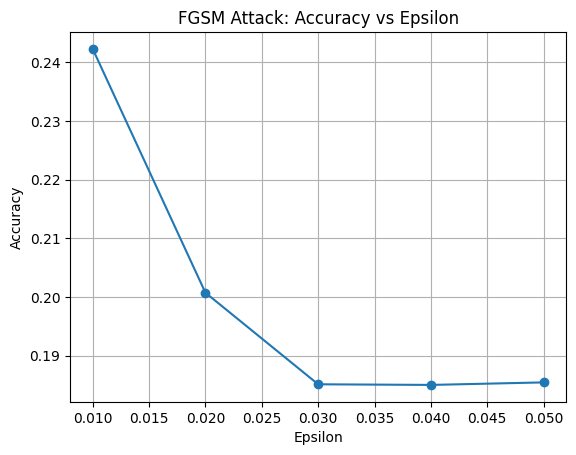

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fgsm_epsilons, fgsm_accuracies, marker='o')
plt.title("FGSM Attack: Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(pgd_epsilons, pgd_accuracies, marker='o')
plt.title("PGD Attack: Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


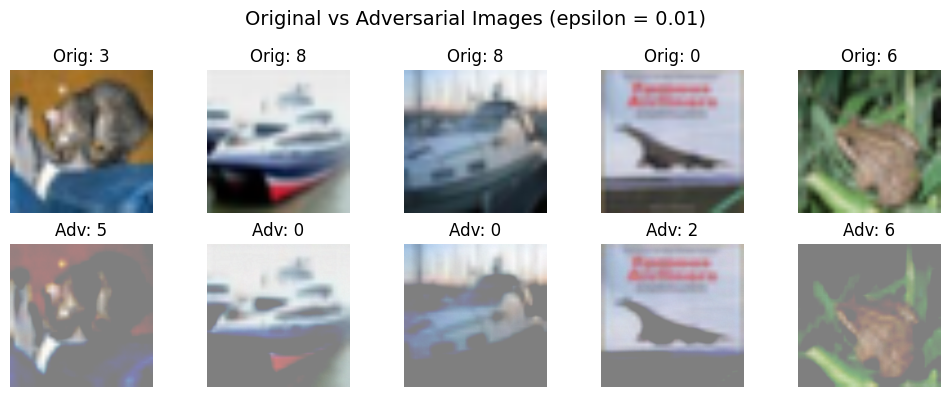

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_examples(epsilons, examples):

  def imshow(img_tensor, title=None):
      img = img_tensor / 2 + 0.5  # unnormalize from [-1, 1] to [0, 1]
      npimg = img.numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      if title:
          plt.title(title)
      plt.axis('off')

  # Pick epsilon to visualize (e.g., epsilon = 0.05)
  epsilon_idx = 0  # or -1 for last epsilon
  example_data = examples[epsilon_idx]

  # Display first N examples
  N = min(5, len(example_data))
  plt.figure(figsize=(2 * N, 4))
  for i in range(N):
      orig_label, adv_label, orig_img, pert_img = example_data[i]

      # Original
      plt.subplot(2, N, i + 1)
      imshow(orig_img, title=f"Orig: {orig_label}")

      # Perturbed
      plt.subplot(2, N, i + 1 + N)
      imshow(pert_img, title=f"Adv: {adv_label}")

  plt.suptitle(f"Original vs Adversarial Images (epsilon = {epsilons[epsilon_idx]})", fontsize=14)
  plt.tight_layout()
  plt.show()

show_examples(fgsm_epsilons, fgsm_examples)
show_examples(pgd_epsilons, pgd_examples)
